# Preparing

## Imports and Functions

In [1]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import regex as re
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, Sequential, layers, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from random import sample
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip -uq "/content/drive/My Drive/Felix/code/AgeRecognition/raw_data/UTKFace.zip" -d "/content/"
#folder_path = '/content/drive/My Drive/Felix/code/AgeRecognition/raw_data/Faces'
folder_path = '/content/Faces'

In [4]:
def load_images_from_folder(folder_path, percent = 50):
    filenames = [f for f in os.listdir(folder_path) if not f.startswith('.')]
    filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
    images = []
    for filename in filenames:
        img = cv2.imread(os.path.join(folder_path,filename),cv2.IMREAD_UNCHANGED)
        
        scale_percent = percent # percent of original size
        width = int(img.shape[1] * scale_percent / 100)
        height = int(img.shape[0] * scale_percent / 100)
        dim = (width, height)
        
        # resize image
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        if img is not None:
            img_colors = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
            images.append(img_colors)
    return images

def show_all_images_from_list(img_list,img_df):
    n=int(len(img_list)/5) +1 
    f = plt.figure(figsize=(25,n*5))
    for i,img in enumerate(img_list):
        f.add_subplot(n, 5, i + 1)
        plt.title(f'{img_df.iloc[i]}',
                  fontweight="bold",
                  fontsize=15)
        plt.imshow(img)
        f.tight_layout()

def load_image_data_into_dataframe(folderpath):

    filenames = [f for f in os.listdir(folder_path) if not f.startswith('.')]
    filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
    df = pd.DataFrame()
    for filename in filenames:
        if filename.startswith('81'):
            break
        parsed_name = filename.split('_')
        df= df.append({'age' : int(parsed_name[0]),
                       #'gender' : parsed_name[1],
                       #'race' : parsed_name[2]
                       }, ignore_index=True)
    #df['gender'] = df['gender'].map({'0': 'male', '1': 'female'})
    #df['race'] = df['race'].map({'0': 'White', '1': 'Black', '2': 'Asian', '3': 'Indian', '4': 'Others'})
    return df

In [55]:
img_pic=load_images_from_folder(folder_path,percent = 50)

In [56]:
img_df = load_image_data_into_dataframe(folder_path)

## Targets into Age Bins (Baseline: 12,5%)

In [58]:
img_df['age_group'] = pd.qcut(img_df['age'],8).astype(str)
img_df['age_group'] = img_df['age_group'].map({
    '(0.999, 8.0]' : 0,
    '(8.0, 23.0]' : 1,
    '(23.0, 26.0]': 2,
    '(26.0, 29.0]': 3,
    '(29.0, 35.0]':4,
    '(35.0, 43.0]':5,
    '(43.0, 55.0]':6,
    '(55.0, 80.0]':7})

## CNN Preperations

In [8]:
#sample_6000 = sample(22005,6000)

In [59]:
#X = img_pic[sample_6000]
#y = img_df['age_group'][sample_6000]
X = img_pic
y = img_df['age_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train = np.array(X_train)
X_test =np.array(X_test)
y_train = np.array(y_train)
y_test =np.array(y_test)

In [61]:
pd.DataFrame(y).value_counts()

age_group
2            3498
4            3038
1            2939
0            2817
7            2741
6            2668
5            2366
3            1938
dtype: int64

In [52]:
pd.DataFrame(y_test).value_counts()

2    346
1    322
7    293
4    293
0    271
6    267
5    222
3    187
dtype: int64

In [10]:
X_train = X_train/255 - 0.5
X_test = X_test/255 - 0.5
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [11]:
del X,y
del img_df,img_pic

In [15]:
print(X_train.shape)
print(X_test.shape)
print(y_test_cat.shape)

(19804, 100, 100, 3)
(2201, 100, 100, 3)
(2201, 8)


# CNN Model_Cifar: Best 46,4 %

In [16]:
def initialize_compile_model(l_rate=0.001):
    model = models.Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2], 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (2, 2), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(y_test_cat.shape[1], activation='softmax'))
    
    opt = optimizers.Adam(learning_rate=l_rate)
    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return model

def plot_history(history, title='', axs=None, exp_name=""):
    plt.figure(figsize=(15,5))
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [17]:
learning_rate=[0.0001, 0.001, 0.01, 0.1, 1]


model_Cifar = initialize_compile_model(l_rate=0.001)

es = EarlyStopping(patience=15,restore_best_weights=True)

history_Cifar = model_Cifar.fit(X_train, y_train_cat, 
                                validation_split=0.3,
                                callbacks=[es],
                                epochs=100, 
                                batch_size=32, 
                                verbose=2)

print(f'Score: {model_Cifar.evaluate(X_test, y_test_cat, verbose=0)[1]}')

Epoch 1/100
434/434 - 20s - loss: 1.7679 - accuracy: 0.3092 - val_loss: 1.5428 - val_accuracy: 0.4059
Epoch 2/100
434/434 - 20s - loss: 1.5114 - accuracy: 0.4074 - val_loss: 1.5078 - val_accuracy: 0.4095
Epoch 3/100
434/434 - 20s - loss: 1.4242 - accuracy: 0.4376 - val_loss: 1.4182 - val_accuracy: 0.4416
Epoch 4/100
434/434 - 20s - loss: 1.3503 - accuracy: 0.4670 - val_loss: 1.3943 - val_accuracy: 0.4539
Epoch 5/100
434/434 - 20s - loss: 1.3045 - accuracy: 0.4833 - val_loss: 1.3560 - val_accuracy: 0.4571
Epoch 6/100
434/434 - 21s - loss: 1.2654 - accuracy: 0.4994 - val_loss: 1.3589 - val_accuracy: 0.4557
Epoch 7/100
434/434 - 20s - loss: 1.2221 - accuracy: 0.5121 - val_loss: 1.3449 - val_accuracy: 0.4559
Epoch 8/100
434/434 - 21s - loss: 1.1947 - accuracy: 0.5245 - val_loss: 1.3479 - val_accuracy: 0.4640
Epoch 9/100
434/434 - 21s - loss: 1.1661 - accuracy: 0.5403 - val_loss: 1.3414 - val_accuracy: 0.4581
Epoch 10/100
434/434 - 20s - loss: 1.1340 - accuracy: 0.5516 - val_loss: 1.3557 - 

In [47]:
model_Cifar.predict(X_test)[0]

array([0.00107568, 0.02783419, 0.17613994, 0.31511348, 0.15774302,
       0.14231019, 0.1331667 , 0.0351882 , 0.00890362, 0.00252498],
      dtype=float32)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8bd9765ad0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8b1f5d7250>)

<Figure size 1080x360 with 0 Axes>

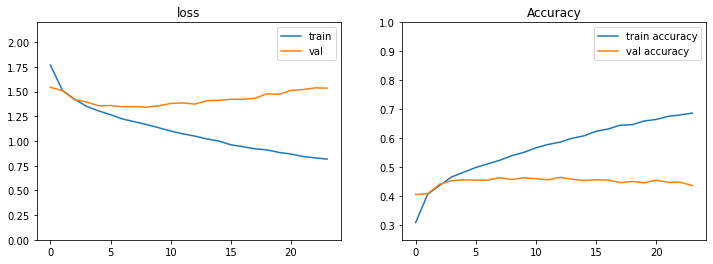

In [18]:
plot_history(history_Cifar)

# Get Rid of Overfitting

## Data Augmentation

In [19]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=(0.8, 1.2),
    ) 

datagen.fit(X_train)

In [20]:
X_augmented_iterator = datagen.flow(X_train, shuffle=False, batch_size=1)

In [22]:
model_Cifar_aug = initialize_compile_model(l_rate=0.001)

X_tr = X_train[:13862]
y_tr = y_train_cat[:13862]
X_val = X_train[13862:]
y_val = y_train_cat[13862:]
train_flow = datagen.flow(X_tr, y_tr, batch_size=64)


#es = EarlyStopping(patience=30)
history_Cifar_aug = model_Cifar_aug.fit(train_flow, 
                                validation_data=(X_val, y_val),
                                #callbacks=[es],
                                epochs=100, 
                                batch_size=32, 
                                verbose=2)

print(f'Score: {model_Cifar_aug.evaluate(X_test, y_test_cat, verbose=0)[1]}')

Epoch 1/100
217/217 - 40s - loss: 1.9292 - accuracy: 0.2455 - val_loss: 1.7921 - val_accuracy: 0.3028
Epoch 2/100
217/217 - 39s - loss: 1.7674 - accuracy: 0.3133 - val_loss: 1.6623 - val_accuracy: 0.3558
Epoch 3/100
217/217 - 40s - loss: 1.7038 - accuracy: 0.3370 - val_loss: 1.6038 - val_accuracy: 0.3815
Epoch 4/100
217/217 - 40s - loss: 1.6594 - accuracy: 0.3512 - val_loss: 1.5639 - val_accuracy: 0.3827
Epoch 5/100
217/217 - 40s - loss: 1.6295 - accuracy: 0.3595 - val_loss: 1.5163 - val_accuracy: 0.3984
Epoch 6/100
217/217 - 39s - loss: 1.6020 - accuracy: 0.3734 - val_loss: 1.4828 - val_accuracy: 0.4128
Epoch 7/100
217/217 - 40s - loss: 1.5791 - accuracy: 0.3808 - val_loss: 1.4714 - val_accuracy: 0.4167
Epoch 8/100
217/217 - 38s - loss: 1.5429 - accuracy: 0.3971 - val_loss: 1.4505 - val_accuracy: 0.4303
Epoch 9/100
217/217 - 41s - loss: 1.5404 - accuracy: 0.3945 - val_loss: 1.4233 - val_accuracy: 0.4339
Epoch 10/100
217/217 - 39s - loss: 1.5151 - accuracy: 0.4023 - val_loss: 1.4166 - 

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8b1cd6c7d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8b1cd5c250>)

<Figure size 1080x360 with 0 Axes>

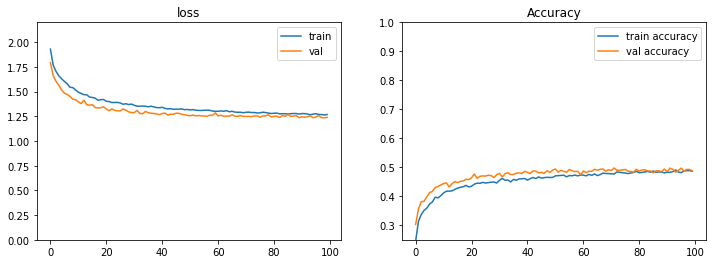

In [23]:
plot_history(history_Cifar_aug)

## Testing the Data Augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


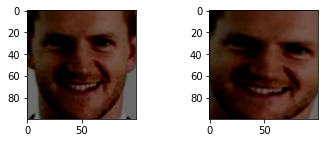

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


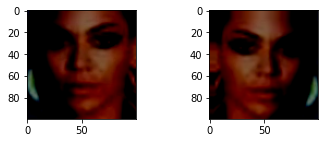

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


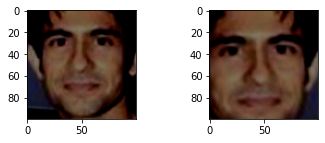

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


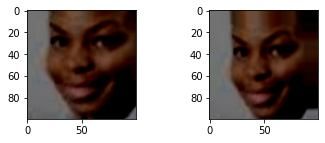

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


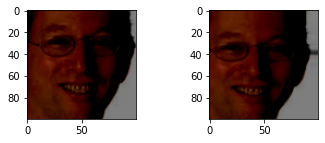

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


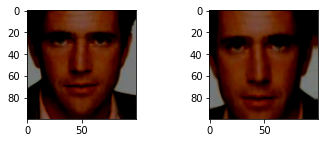

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


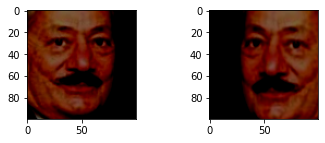

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


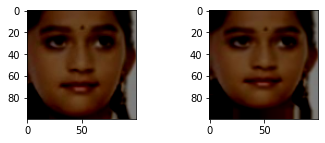

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


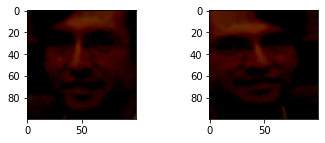

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


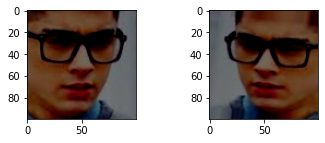

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


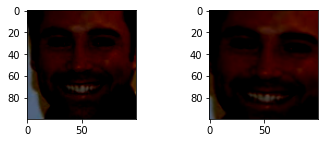

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


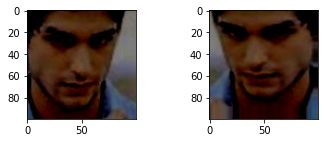

In [23]:
import numpy as np

for i, (raw_image, augmented_image) in enumerate(zip(X_train, X_augmented_iterator)):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))
    ax1.imshow(raw_image)
    ax2.imshow(augmented_image[0])
    plt.show()
    
    if i > 4:
        break

## Dropout

## More Dropout maybe???

# Best Transfer Learning: CNN Model_Resnet50V2   37,5% (Not Good)

In [ ]:
from tensorflow.keras.applications import ResNet50V2

def load_model():
    model = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=X_train[0].shape)
    return model

def set_nontrainable_layers(model):
    model.trainable = False
    return model 
    
def add_last_layers(model):
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(200, activation='relu')
    dropout_layer = layers.Dropout(0.2)
    prediction_layer = layers.Dense(10, activation='softmax')
    
    model = models.Sequential([
        base_model,
        dropout_layer,
        flatten_layer,
        dense_layer,
        dropout_layer,
        prediction_layer
    ])
    return model


def compile_model(model):
    
    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

def build_model():
    model = load_model()
    model = add_last_layers(model)
    model = compile_model(model)
    return model

In [ ]:
print(model_ResNet.summary())

In [ ]:
model_ResNet = build_model()

es = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)

history_ResNet = model_ResNet.fit(X_train, y_train_cat, 
                    validation_split=0.3, 
                    callbacks=[es],
                    epochs=50, 
                    batch_size=32, 
                    verbose=1)

print(f'Score: {model_ResNet.evaluate(X_test, y_test_cat, verbose=0)[1]}')

plot_history(history_ResNet)

# Evaluation

In [24]:
def convert_number(num):
    if num == 0:
        return '1-5'
    elif num == 1:
        return '6-19'
    elif num == 2:
        return '20-25'
    elif num == 3:
        return '26-26'
    elif num == 4:
        return '27-29'
    elif num == 5:
        return '30-34'
    elif num == 6:
        return '35-39'
    elif num == 7:
        return '40-49'
    elif num == 8:
        return '50-58'
    elif num == 9:
        return '59-80'


In [29]:
def show_images_from_list_with_prediction(img_list,real,pred_list):
    n=int(len(img_list)/5) +1 
    f = plt.figure(figsize=(25,n*5))
    for i,img in enumerate(img_list):
        f.add_subplot(n, 5, i + 1)
        plt.title(f'Real: {int(real[i])} \n Prediction: {int(np.argsort(pred_list[i])[-1])}',
                  fontweight="bold",
                  fontsize=15)
        plt.imshow(img)
        f.tight_layout()

In [26]:
X_test_show = (X_test + 0.5)

In [33]:
pred_list_Cifar_aug = model_Cifar_aug.predict(X_test)

In [40]:
pred_list_Cifar_aug[0:2]

array([[5.7163910e-04, 4.9745571e-02, 3.7823454e-01, 1.6937976e-01,
        2.1592721e-01, 1.3472047e-01, 4.6530019e-02, 4.8907869e-03],
       [6.7804198e-05, 4.9237946e-01, 2.1821359e-01, 1.4287877e-01,
        1.0076811e-01, 3.4192741e-02, 9.6745985e-03, 1.8248523e-03]],
      dtype=float32)

In [42]:
np.argsort(pred_list_Cifar_aug[0:2])[:,-1]

array([2, 1])

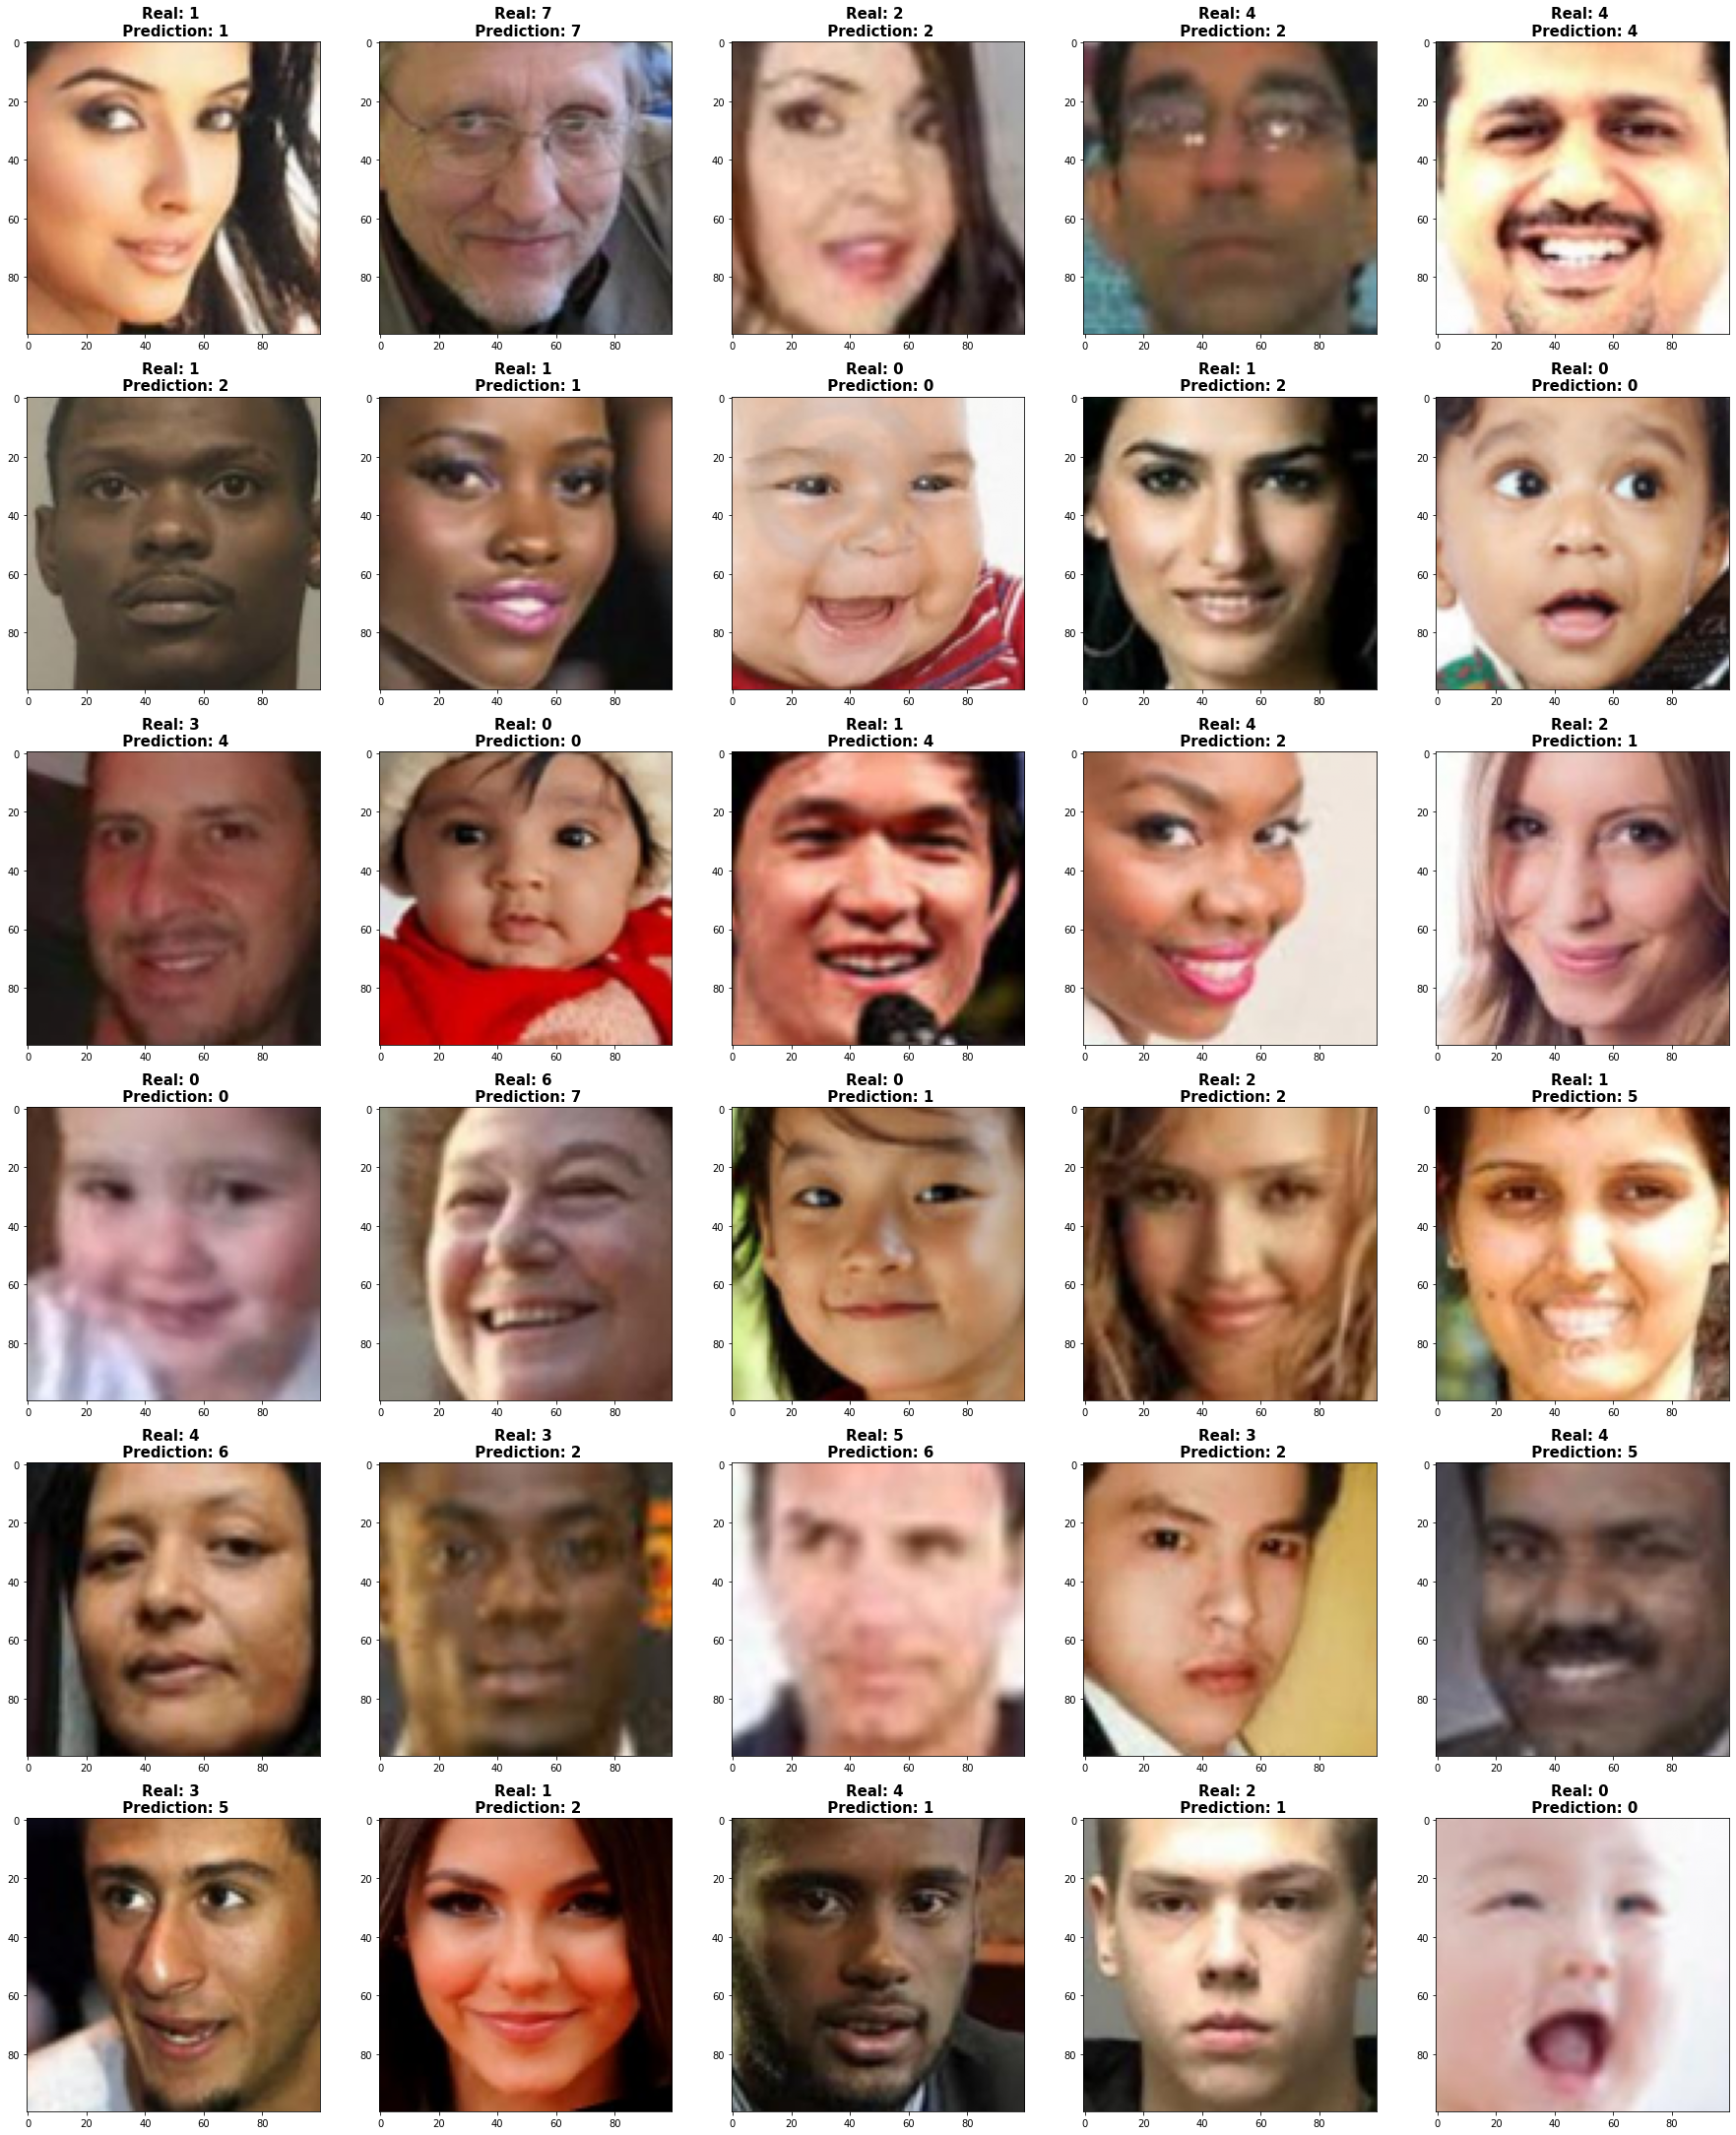

In [31]:
show_images_from_list_with_prediction(X_test_show[40:70],y_test[40:70],pred_list_Cifar_aug[40:70])

# Visualisations

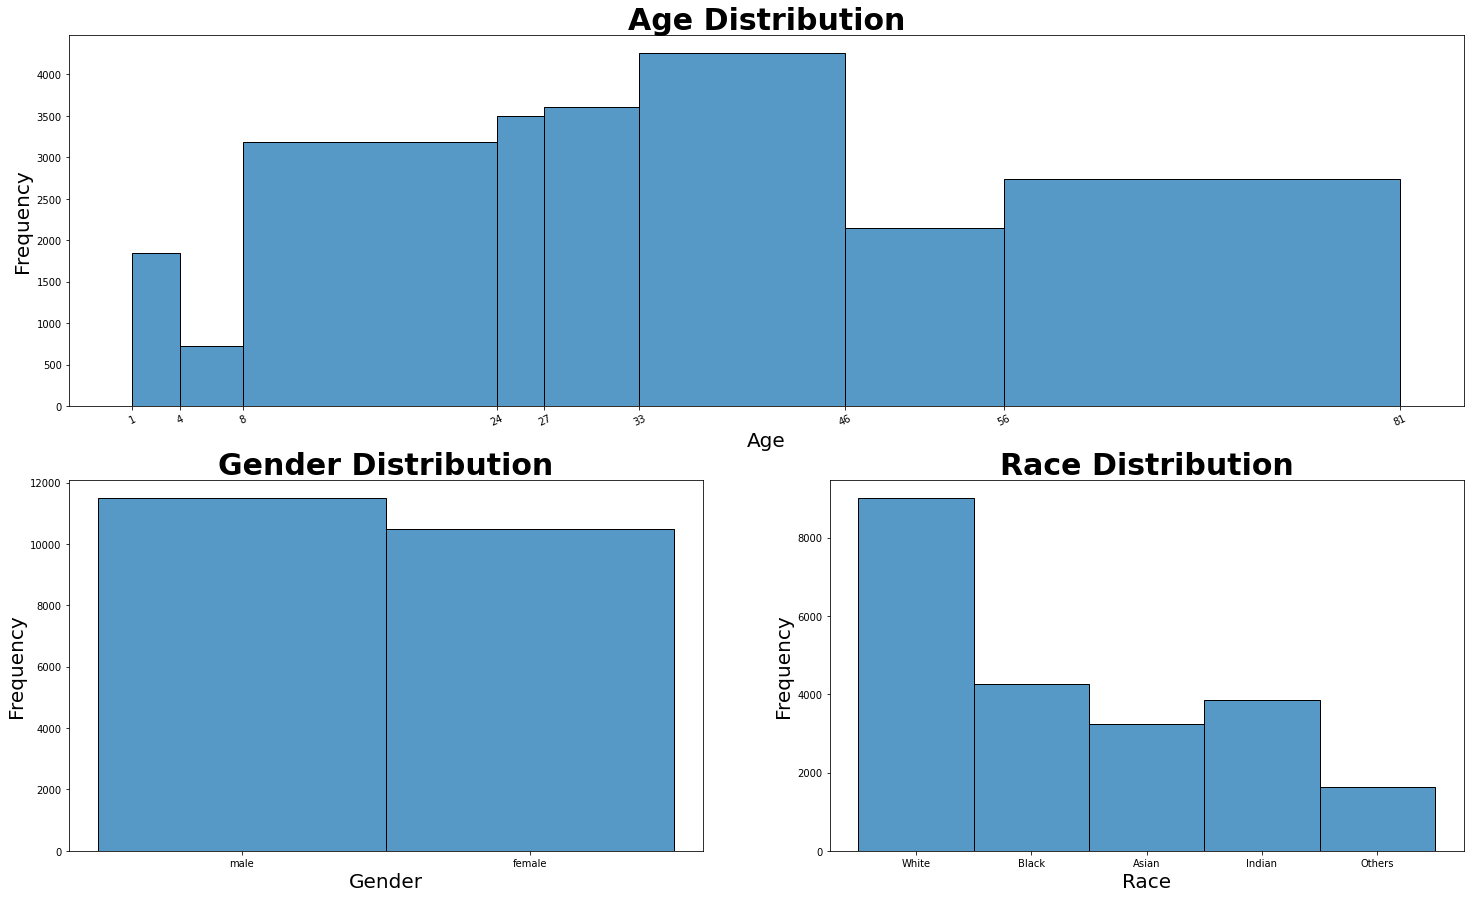

In [63]:
f = plt.figure(figsize=(25,15))
bins_value=[1,4,8,24,27,33,46,56,81]
#bins_value = [0,5,10,15,20,25,27,30,35,40,45,50,55,60,65,70,75,80]
#bins_value = list(range(0,80,1))

#Age Histogram
f.add_subplot(211)
sns.histplot(data=img_df,x = 'age', bins=bins_value)
plt.title('Age Distribution',fontweight="bold",fontsize=30)
plt.xlabel('Age',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks(bins_value, rotation = 25)

# Gender Histogram
f.add_subplot(223)
sns.histplot(img_df['gender'])
plt.title('Gender Distribution',fontweight="bold",fontsize=30)
plt.xlabel('Gender',fontsize=20)
plt.ylabel('Frequency',fontsize=20)

#Race Histogram
f.add_subplot(224)
sns.histplot(img_df['race'])
plt.title('Race Distribution',fontweight="bold",fontsize=30)
plt.xlabel('Race',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks()

plt.show()

In [65]:
pd.qcut(img_df['age'],8).value_counts().sort_index()

(0.999, 8.0]    2817
(8.0, 23.0]     2939
(23.0, 26.0]    3498
(26.0, 29.0]    1938
(29.0, 35.0]    3038
(35.0, 43.0]    2366
(43.0, 55.0]    2668
(55.0, 80.0]    2741
Name: age, dtype: int64

In [63]:
from sklearn.metrics import confusion_matrix, classification_report
print("Confusion matrix:\n%s" % confusion_matrix(y_test, np.argsort(pred_list_Cifar_aug)[:,-1]))

Confusion matrix:
[[236  32   3   0   0   0   0   0]
 [ 17 189  97   2   9   6   1   1]
 [  2  76 217   1  31  12   6   1]
 [  1  31  95   1  39  14   6   0]
 [  1  30 127   1  60  44  29   1]
 [  0   9  44   4  34  57  67   7]
 [  0   5  13   2  25  34 125  63]
 [  0   3   3   0   2  10  68 207]]


In [64]:
print("Classification matrix:\n%s" % classification_report(y_test, np.argsort(pred_list_Cifar_aug)[:,-1]))

Classification matrix:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       271
           1       0.50      0.59      0.54       322
           2       0.36      0.63      0.46       346
           3       0.09      0.01      0.01       187
           4       0.30      0.20      0.24       293
           5       0.32      0.26      0.29       222
           6       0.41      0.47      0.44       267
           7       0.74      0.71      0.72       293

    accuracy                           0.50      2201
   macro avg       0.46      0.47      0.45      2201
weighted avg       0.47      0.50      0.47      2201



In [47]:
pd.DataFrame(y_test).value_counts().sort_index()

0    271
1    322
2    346
3    187
4    293
5    222
6    267
7    293
dtype: int64

In [62]:
pd.DataFrame(y).value_counts()

age_group
2            3498
4            3038
1            2939
0            2817
7            2741
6            2668
5            2366
3            1938
dtype: int64